In [1]:
import pandas_datareader.data as web
from datetime import date
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Load Data

In [2]:
def data_collection(ticker, start, end):
    
    df = web.DataReader(ticker, "yahoo", start, end)
        
    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
    
    # Change the index type to date
    as_list = df.index.tolist()
    unix_epoch = np.datetime64(0, 's')
    one_second = np.timedelta64(1, 's')
    for i in range(len(as_list)):
        seconds_since_epoch = (as_list[i] - unix_epoch) / one_second
        as_list[i] = datetime.datetime.utcfromtimestamp(seconds_since_epoch).date()

    df.index = as_list

    return df

In [437]:
# Load Data
df = data_collection('AMZN', datetime.date(2019,1,1), datetime.date.today())
df.tail()

,high,low,open,close,volume,adj_close
2020-03-20,1957.000000,1820.729980,1926.310059,1846.089966,9817900,1846.089966
2020-03-23,1919.400024,1812.000000,1827.750000,1902.829956,7808500,1902.829956
2020-03-24,1955.000000,1900.339966,1951.500000,1940.099976,7147100,1940.099976
2020-03-25,1950.260010,1885.780029,1920.689941,1885.839966,6479100,1885.839966
2020-03-26,1956.489990,1889.290039,1902.000000,1955.489990,6221300,1955.489990


###  Add the latest price if the df is up-to-date

In [3]:
df = data_collection('AAPL', datetime.date(2019,1,1), datetime.date.today())
test_price = 242.31
df.loc[-1] = [0, 0, 0, test_price, 0, 0]
df.index.values[len(df)-1] = date.today()
df.tail()

,high,low,open,close,volume,adj_close
2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500.0,254.289993
2020-04-01,248.720001,239.130005,246.500000,240.910004,44054600.0,240.910004
2020-04-02,245.149994,236.899994,240.339996,244.929993,41419200.0,244.929993
2020-04-03,245.699997,241.559998,242.800003,242.380600,13055024.0,242.380600
2020-04-03,0.000000,0.000000,0.000000,242.310000,0.0,0.000000


## Signal

In [36]:
# Initialize the short and long windows
short_window = 5
long_window = 10

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['price'] = df['close']

# Create short simple moving average over the short window
signals['short_mavg'] = df['close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = df['close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['position'] = signals['signal'].diff()

# Print signals
# Sell
signals.loc[signals.position == -1.0].tail()
# Buy
#signals.loc[signals.position == 1.0].tail()

,signal,price,short_mavg,long_mavg,position
2020-01-31,0.0,309.510010,316.872003,317.490005,-1.0
2020-02-05,0.0,321.450012,316.468005,317.086005,-1.0
2020-02-20,0.0,320.299988,322.547998,322.633997,-1.0
2020-03-11,0.0,275.429993,281.778003,284.663998,-1.0
2020-04-03,0.0,242.310000,244.964118,247.821060,-1.0


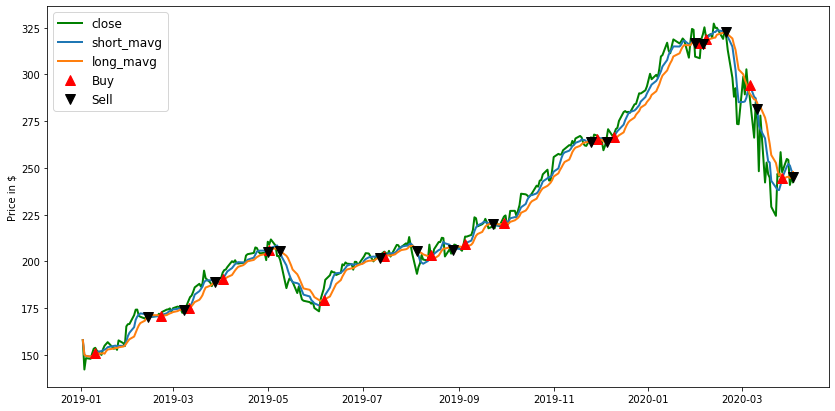

In [37]:
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure(figsize=(14,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['close'].plot(ax=ax1, color='green', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.position == 1.0].index, 
         signals.short_mavg[signals.position == 1.0],
         '^', markersize=10, color='red', label = 'Buy')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.position == -1.0].index, 
         signals.short_mavg[signals.position == -1.0],
         'v', markersize=10, color='black', label = 'Sell')
         
# Show the plot
plt.legend(loc='upper left', fontsize=12)
plt.show()

## Return

In [9]:
def trade_info(signals, cash):
    # Get the trade information from signal df
    trade_info = signals.loc[(signals["position"] == 1.0) | (signals["position"] == -1.0)]
    trade_info = trade_info[['price', 'position']]
    
    # Check whether the first action is buy and the last action is sell
    if trade_info.loc[trade_info.index.values[0], 'position'] == -1:
        trade_info = trade_info.drop(trade_info.index[0])
    if len(trade_info) == 0:
        raise Exception("No signal!")
    if trade_info.loc[trade_info.index.values[len(trade_info)-1], 'position'] == 1.0:
        trade_info = trade_info.drop(trade_info.index[len(trade_info)-1])
    if len(trade_info) == 0:
        raise Exception("No signal!")

        
    # Initialize the first trade
    trade_info.loc[trade_info.index.values[0], "cash_0"] = cash
    trade_info['quantity'] = trade_info['cash_0'] // trade_info['price'] 
    trade_info['value'] = trade_info['position']* trade_info['price'] * trade_info['quantity']
    trade_info['cash_1'] = trade_info['cash_0'] - trade_info['value']
    
    for i in range(1, len(trade_info)):
        # new cash_0
        trade_info.loc[trade_info.index.values[i], "cash_0"] = trade_info.loc[trade_info.index.values[i-1], "cash_1"]

        # trade quantity
        if(trade_info.loc[trade_info.index.values[i-1], "position"] == 1): 
            trade_info.loc[trade_info.index.values[i], "quantity"] = trade_info.loc[trade_info.index.values[i-1], "quantity"]
        else: 
            trade_info.loc[trade_info.index.values[i], "quantity"] = trade_info.loc[trade_info.index.values[i], "cash_0"] // trade_info.loc[trade_info.index.values[i], "price"]

        # value
        trade_info['value'] = trade_info['position']* trade_info['price'] * trade_info['quantity']

        # cash_1
        trade_info['cash_1'] = trade_info['cash_0'] - trade_info['value']
    
    return trade_info
    
    

In [33]:
signals.loc[(signals["position"] == 1.0) | (signals["position"] == -1.0)]

,signal,price,short_mavg,long_mavg,position
2019-01-17,1.0,155.860001,152.020999,151.693333,1.0
2019-05-15,0.0,190.919998,199.833998,201.148000,-1.0
2019-06-17,1.0,193.889999,189.990999,188.327000,1.0
2019-08-09,0.0,200.990005,203.774997,203.964333,-1.0
2019-08-21,1.0,212.639999,205.821001,205.246333,1.0
2020-02-25,0.0,288.079987,315.885995,316.857666,-1.0


In [38]:
cash = 3000
trade = trade_info(signals, cash)
trade

,price,position,cash_0,quantity,value,cash_1
2019-01-10,153.800003,1.0,3000.000000,19.0,2922.200058,77.799942
2019-02-13,170.179993,-1.0,77.799942,19.0,-3233.419861,3311.219803
2019-02-21,171.059998,1.0,3311.219803,19.0,3250.139954,61.079849
2019-03-08,172.910004,-1.0,61.079849,19.0,-3285.290070,3346.369919
2019-03-11,178.899994,1.0,3346.369919,18.0,3220.199890,126.170029
2019-03-28,188.720001,-1.0,126.170029,18.0,-3396.960022,3523.130051
2019-04-02,194.020004,1.0,3523.130051,18.0,3492.360077,30.769974
2019-05-01,210.520004,-1.0,30.769974,18.0,-3789.360077,3820.130051
2019-05-02,209.149994,1.0,3820.130051,18.0,3764.699890,55.430161
2019-05-09,200.720001,-1.0,55.430161,18.0,-3612.960022,3668.390182


In [29]:
def gain_return(trade):
    gain = trade.loc[trade.index.values[len(trade)-1], "cash_1"] - trade.loc[trade.index.values[0], "cash_0"]
    inv_return = gain / trade.loc[trade.index.values[0], "cash_0"]
    
    data = {'Gain':[gain], 'Return': [inv_return]}
    out = pd.DataFrame(data)
    
    return out

In [39]:
gain = gain_return(trade).iloc[0][0]
inv_return = gain_return(trade).iloc[0][1]

print('Earning is: %.2f' %gain)
print("Return Rate is: %.2f%%" %(inv_return*100))

Earning is: 2168.41
Return Rate is: 72.28%


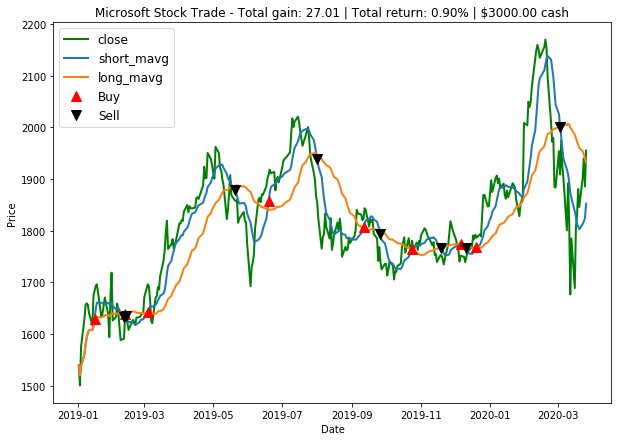

In [446]:
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure(figsize=(10,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['close'].plot(ax=ax1, color='green', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.position == 1.0].index, 
         signals.short_mavg[signals.position == 1.0],
         '^', markersize=10, color='red', label = 'Buy')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.position == -1.0].index, 
         signals.short_mavg[signals.position == -1.0],
         'v', markersize=10, color='black', label = 'Sell')
         
# Show the plot
plt.title('Microsoft Stock Trade - Total gain: %.2f | Total return: %.2f%% | $%.2f cash' %(gain, (inv_return*100), cash))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', fontsize=12)
plt.show()


## DCF

In [299]:
import os, sys
print("\t\t[Intrinsic Stock Price Estimator for APPLE]")

NetCashFlow = 69390 # Net cash ~ millions
sharesTotal = 4649 # Shares outstanding ~ millions
debt = 93078 / sharesTotal # Total Debt ~ millions
cash = 107162 / sharesTotal # Cash + Short term investment ~ millions
rate = 25 # Long-Term EPS Growth %

rate2 = rate / 2

cashFlow = [1] * 10
cashFlow[0] = NetCashFlow * (rate / 100 + 1)

#discountFactor=[0.92, 0.8464, 0.7787, 0.7164, 0.6591, 0.6064, 0.5578, 0.5132, 0.4722, 0.434]

discountFactor = []
r = 0.0766
for i in range(1,11):
    discountFactor.append(1/(1+r)**i) 

discountedValues=[1] * 10
discountedValues[0] = discountFactor[0] * cashFlow[0]

FinalTotal = 0
Sum = discountedValues[0]

print(discountedValues)
for i in range(1,10):
    if i < 5:
        growthRate = (rate / 100) + 1
        cashFlow[i] = cashFlow[i-1] * growthRate
        discountedValues[i] = discountFactor[i] * cashFlow[i]
        Sum += discountedValues[i]
    else:
        growthRate = (rate2 / 100) + 1
        cashFlow[i] = cashFlow[i-1] * (growthRate)
        discountedValues[i] = discountFactor[i] * cashFlow[i]
        Sum += discountedValues[i]

sharesTotal = Sum / sharesTotal
FinalTotal = sharesTotal - debt + cash
#print(f"\t\tSum: {round(Sum,2)}")
print(f"\t\tValue per Share: ${round(sharesTotal, 2)}")
#print(f"\t\tDebt (-{round(debt,2)}) Cash (+{round(cash,2)})")
print(f"\t\tIntrinsic Value: ${round(FinalTotal, 2)}")

		[Intrinsic Stock Price Estimator for APPLE]
[80566.13412595207, 1, 1, 1, 1, 1, 1, 1, 1, 1]
		Value per Share: $299.45
		Intrinsic Value: $302.48


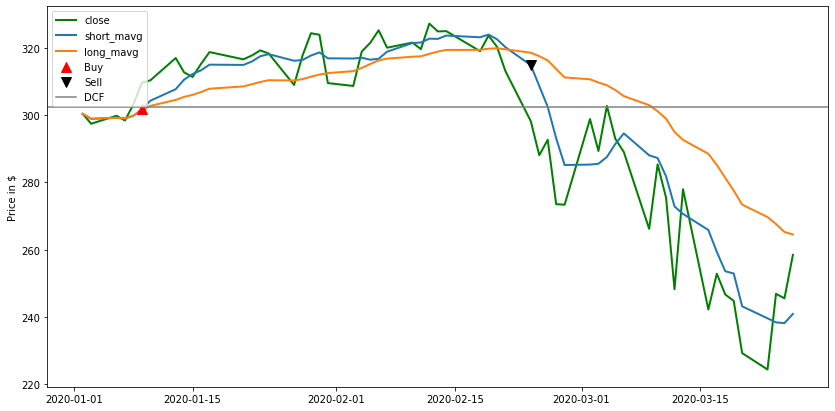

In [326]:
# Initialize the plot figure
fig = plt.figure(figsize=(14,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['close'].plot(ax=ax1, color='green', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.position == 1.0].index, 
         signals.short_mavg[signals.position == 1.0],
         '^', markersize=10, color='red', label = 'Buy')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.position == -1.0].index, 
         signals.short_mavg[signals.position == -1.0],
         'v', markersize=10, color='black', label = 'Sell')

# Plot the DCF value
plt.axhline(y=FinalTotal, color='gray', linestyle='-', label = 'DCF')
         
# Show the plot
plt.legend(loc='upper left', fontsize=10)
plt.show()

## Portfolio

In [447]:
2311.62+27.01+1600.67

3939.3

In [449]:
3939.3/10000

0.39393

In [448]:
2906.72+27.01+1252.07

4185.8

In [451]:
(4185.8-3939.3)/3939.3

0.0625745690858782

In [452]:
4185.8-3939.3

246.5